In [3]:
import pandas as pd

data_base = pd.read_csv("./data/household_power_consumption.txt",
                        header=0,
                        squeeze=True,
                        delimiter=";",
                        na_values=["?"],
                        dtype={
                            "Time": str,
                            "Date": str,
                            "Global_active_power": float,
                            "Global_reactive_power": float,
                            "Voltage": float,
                            "Global_intensity": float,
                            "Sub_metering_1": float,
                            "Sub_metering_2": float,
                            "Sub_metering_3": float
                        })

data_base["timestamp"] = pd.to_datetime(data_base["Date"] + " " + data_base["Time"], format="%d/%m/%Y %H:%M:%S")
data_base["date_filter"] = pd.to_datetime(data_base["Date"] + " " + data_base["Time"], format="%d/%m/%Y %H:%M:%S")
data_base = data_base.set_index("timestamp")

data_base.head(5).style

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_filter
timestamp,,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216000,0.418000,234.840000,18.400000,0.000000,1.000000,17.000000,2006-12-16 17:24:00
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360000,0.436000,233.630000,23.000000,0.000000,1.000000,16.000000,2006-12-16 17:25:00
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374000,0.498000,233.290000,23.000000,0.000000,2.000000,17.000000,2006-12-16 17:26:00
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388000,0.502000,233.740000,23.000000,0.000000,1.000000,17.000000,2006-12-16 17:27:00
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666000,0.528000,235.680000,15.800000,0.000000,1.000000,17.000000,2006-12-16 17:28:00


In [4]:
start_date = "2007-01-01"
end_date = "2007-01-15"
feature = "Global_active_power"

def clean_data(dataframe):
    date_range = (data_base["date_filter"] >= start_date) & (data_base["date_filter"] < end_date)
    return dataframe.dropna(subset=[feature]).loc[date_range].resample("60min", on="date_filter").mean()[feature]

series = clean_data(data_base)

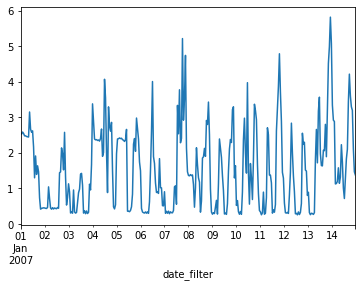

In [5]:
import matplotlib as plt

series.plot()
plt.pyplot.show()

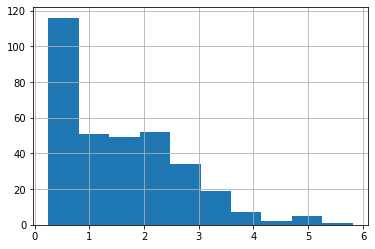

In [6]:
series.hist()
plt.pyplot.show()

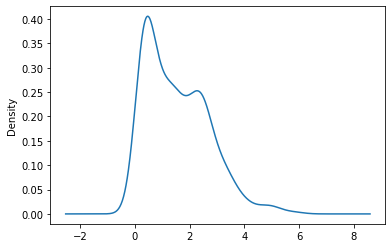

In [7]:
series.plot(kind="kde")
plt.pyplot.show()

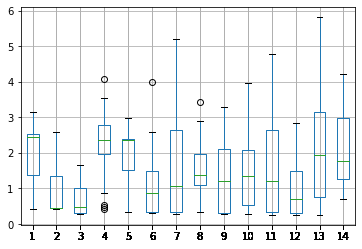

In [8]:
pd.DataFrame(series).set_index(series.index.day, append=True).unstack().boxplot()
plt.pyplot.xticks(series.index.day, list(series.index.day))
plt.pyplot.show()

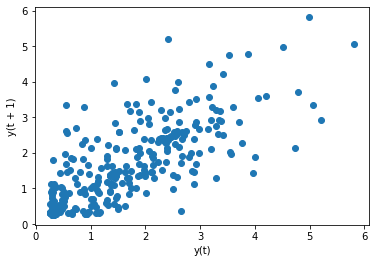

In [9]:
pd.plotting.lag_plot(series)
plt.pyplot.show()

Existe uma boa correlação temporal na base de dados escolhida.

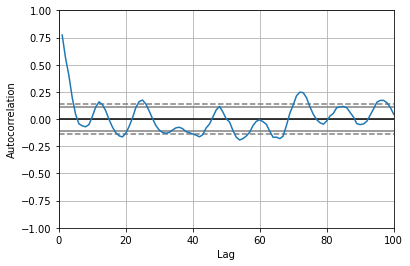

In [14]:
pd.plotting.autocorrelation_plot(series)
plt.pyplot.xlim([0,100])
plt.pyplot.show()